#### Prediction of missing eye tracking data with neural networks
Lucas D. Haberkamp<sup>1,2,3</sup>, Michael D. Reddix<sup>1</sup>

<sup>1</sup>Naval Medical Research Unit - Dayton  
<sup>2</sup>Oak Ridge Institute for Science and Education  
<sup>3</sup>Leidos   

---

This script trains a temporal convolutional network to predict the 3D point of gaze coordinates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn import utils
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

"extractdf" is a function which reads each file as a dataframe and saves the dataframe to a list and also saves a separate list of the filenames.

In [2]:
# fill_nan should be used with classification ground truth data. prevents a nan label.
def extractdf(data_path, fill_nan=False):
    file_list, df_list = [], [] # initialize lists
    for filename in os.listdir(data_path):
        f = os.path.join(data_path, filename) 
        if os.path.isfile(f):
            current_file = os.path.splitext(filename)[0].split('_')[0] # get the identifier of the participant from the file
            file_list.append(current_file)  
            tmp_df = pd.read_csv(f)
            if fill_nan == True:
                tmp_df = tmp_df.fillna(0)
            df_list.append(tmp_df)

    return df_list, file_list

Extract the training and validation data for each file into separate lists for x and y_regression

In [3]:
# Specify paths
trainx_path = '../Data/Prep/train/trainx'
trainy_path = '../Data/Prep/train/trainy-regression'

valx_path = '../Data/Prep/validation/valx'
valy_path = '../Data/Prep/validation/valy-regression'

# Extract the data as dataframes stored into lists
trainx_list, train_file_list = extractdf(trainx_path)
trainy_list, _ = extractdf(trainy_path)  

valx_list, val_file_list = extractdf(valx_path)
valy_list, _ = extractdf(valy_path)

print("Files in the training dataset:", train_file_list)
print("Files in the validation dataset:", val_file_list)

Files in the training dataset: ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P09', 'P11', 'P12', 'P13', 'P14']
Files in the validation dataset: ['P06', 'P10']


Intialize separate MinMaxScaler objects for the inputs and outputs. Scales the data between 0 and 1. 

In [4]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# fit data to the first file in the training dataset
x_scaler.fit(trainx_list[0].values)
y_scaler.fit(trainy_list[0].values)

MinMaxScaler()

Function to add gaussian noise to a signal. The scale is set as a proportion of the standard deviation.

In [5]:
def getnoise(x, scale):
    
    noise = []
    mean = 0
    mu = scale
    for i in range(x.shape[1]):
        random_vector = np.random.normal(mean, mu, x.shape[0])
        noise.append(random_vector * np.std(x[:,i]))

    noise = np.array(noise).transpose()
    x = x + noise
    
    return x

Function to prep the data by creating 3D input tensors, while not including nans in the 2D target tensors.

In [6]:
def dataprep(file_list, x_list, y_list, addnoise, scale):
    
    batch_size = 1024
    window_size = 256
    shuffle_buffer_size = 1000
    dataset_list = []
    for i in range(len(file_list)):
        if addnoise:
            curr_x = getnoise(x_scaler.transform(x_list[i].values), scale)   
        else:
            curr_x = x_scaler.transform(x_list[i].values)   

        curr_y = y_scaler.transform(y_list[i].values)

        if i==0:
            col_names = x_list[i].columns

            tmp_x = x_scaler.transform(x_list[i].values)
            for k in range(curr_x.shape[1]):
                print(col_names[k])
                plt.plot(curr_x[:1000,k])
                plt.plot(tmp_x[:1000,k])
                plt.show()
                
        x = tf.data.Dataset.from_tensor_slices(curr_x)
        x = x.window(window_size, shift=1, drop_remainder=True)
        x = x.flat_map(lambda w: w.batch(window_size))
        
        y = tf.data.Dataset.from_tensor_slices(curr_y[window_size-1:])
        
        filter_nan = lambda x, y: not tf.reduce_any(tf.math.is_nan(x)) and not tf.reduce_any(tf.math.is_nan(y))
        
        tmp_ds = tf.data.Dataset.zip((x,y)).filter(filter_nan)
        dataset_list.append(tmp_ds)
    
    dataset = dataset_list[0]
    
    for j in range(1, len(dataset_list)):
        dataset = dataset.concatenate(dataset_list[j])
        
    dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


Construct the the TCN, train the model, and assess the training performance. 

In [7]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [10]:
# Construct the TCN model 

# list of dilation rates to be used in the model
dilation_rates = [1,2,4,8,16,32,64,128]

# input layer (Sequences have length 256 & 14 features)
inputs = Input(shape=(256, 14))
# intialize array to concatenate outputs from residual blocks with different dilations
skips = []

x = inputs
# Generate an output for each residual block
for dilation in dilation_rates:
    # Inital 1x1 Convolution
    x = Conv1D(32, kernel_size=1, padding='same', activation='relu')(x)

    # Dilated Convolutions with tanh and sigmoid activations 
    x_f = Conv1D(8, kernel_size=2, padding="causal", 
                 dilation_rate=dilation, activation='tanh')(x)
    
    x_g = Conv1D(8, kernel_size=2, padding="causal", 
                 dilation_rate=dilation, activation='sigmoid')(x)
    
    # apply the gate
    z = Multiply()([x_f, x_g])

    # 1x1 convolution
    z = Conv1D(32, kernel_size=1, padding='same', activation='relu')(z)
    
    # append output of the residual block
    skips.append(z)

    # make use of residual connection 
    res = Add()([x, z])

# Add all the skip connections and pass through ReLU activation
x = Activation('relu')(Add()(skips))

# Predict output for each time step
x = Conv1D(3, kernel_size=1, padding='same')(x)

# function to return only the final gaze point label from the predictions
def slice(x):
    return x[:, -1, :]

# Define output layer as the prediction for the final time step
outputs = Lambda(slice)(x)

# define model
model = Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 14)]    0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 256, 32)      480         ['input_3[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 256, 32)      1056        ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 256, 32)      1056        ['conv1d_8[0][0]']               
                                                                                              

In [10]:
# Set training parameters for tcn
optimizer = Adam(learning_rate=1e-3)
loss = 'mae'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=20, verbose=1, restore_best_weights=True)

model.compile(loss=loss, optimizer=optimizer)

Gathering sequences for the training dataset.

LeftGazeDirection_x


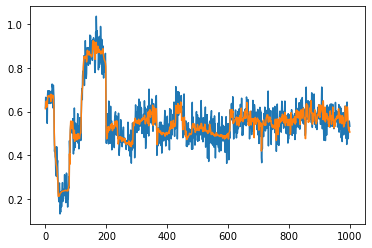

LeftGazeDirection_y


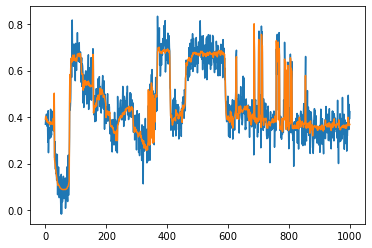

LeftGazeDirection_z


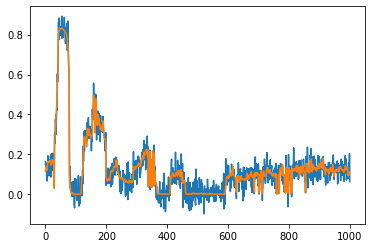

RightGazeDirection_x


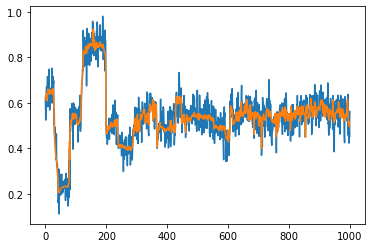

RightGazeDirection_y


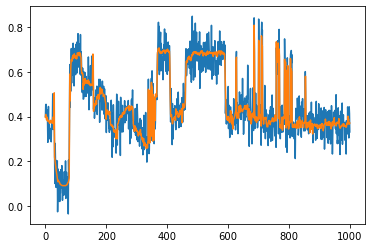

RightGazeDirection_z


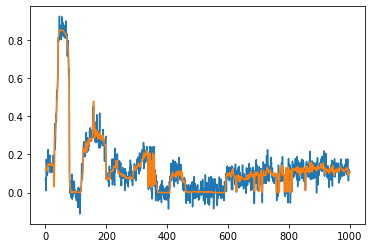

LeftGazeOrigin_x


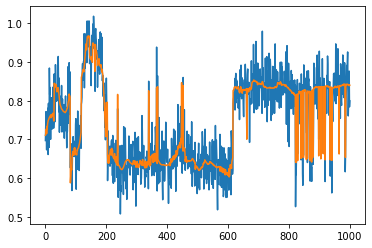

LeftGazeOrigin_y


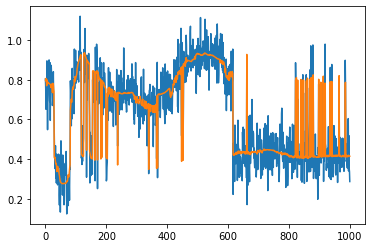

LeftGazeOrigin_z


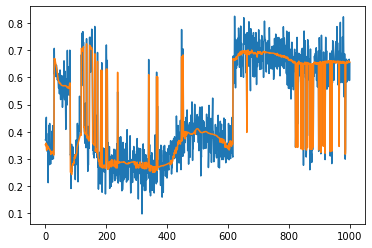

RightGazeOrigin_x


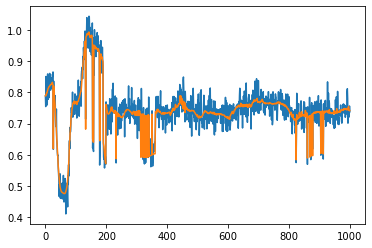

RightGazeOrigin_y


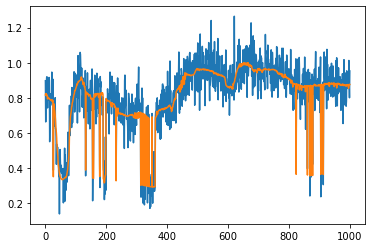

RightGazeOrigin_z


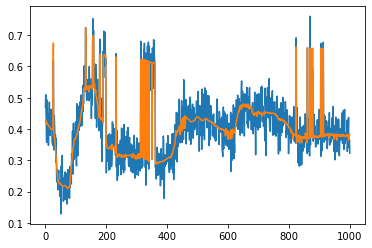

LeftEyelidOpening


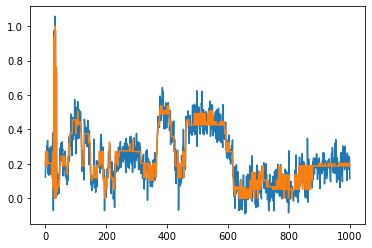

RightEyelidOpening


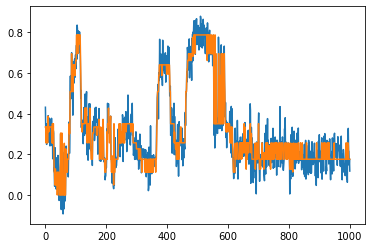

Gathering sequences for the validation dataset.

LeftGazeDirection_x


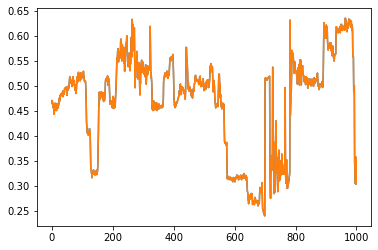

LeftGazeDirection_y


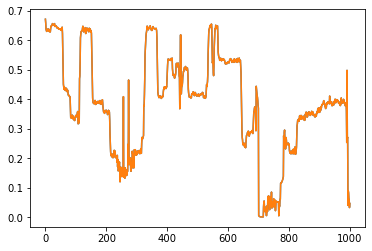

LeftGazeDirection_z


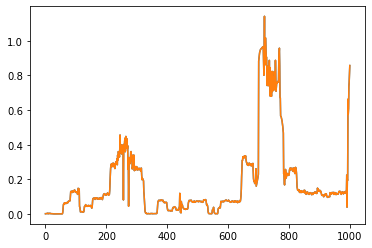

RightGazeDirection_x


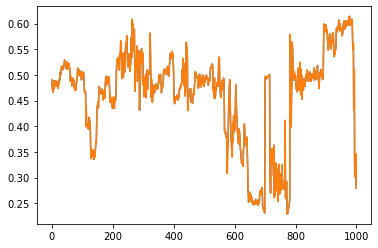

RightGazeDirection_y


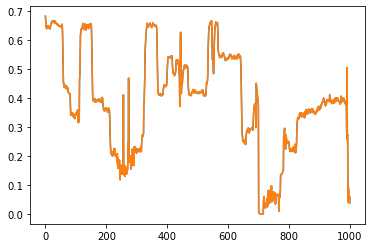

RightGazeDirection_z


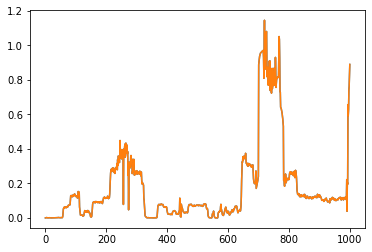

LeftGazeOrigin_x


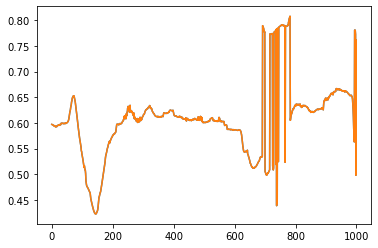

LeftGazeOrigin_y


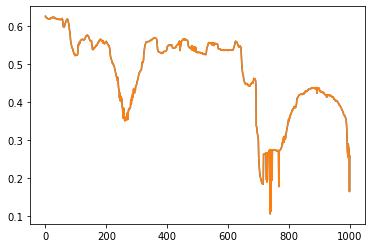

LeftGazeOrigin_z


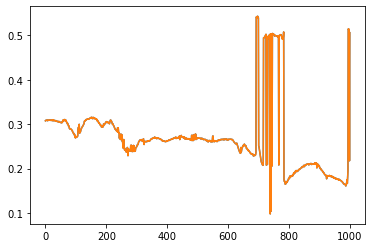

RightGazeOrigin_x


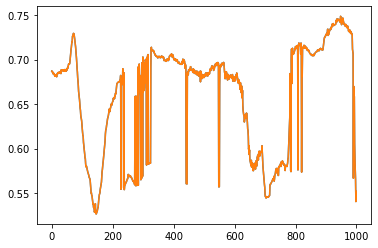

RightGazeOrigin_y


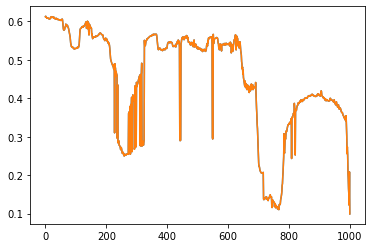

RightGazeOrigin_z


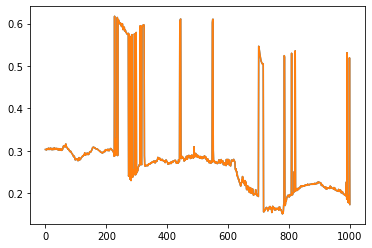

LeftEyelidOpening


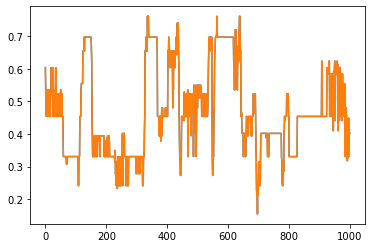

RightEyelidOpening


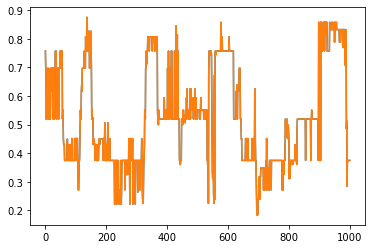

Current Scale is: 0.4
Epoch 1/200
      7/Unknown - 13s 2s/step - loss: 0.3123

KeyboardInterrupt: 

In [11]:
# train the model with an adaptive noise level (0.4 --> 0.2 --> 0.0)*stdev of the feature

train_eval = [] # itialize list to store training history at each noise level

for i in reversed(range(0,5,2)):
    scale = i/10 # set the noise level

    print("Gathering sequences for the training dataset.\n")
    train_ds = dataprep(train_file_list, trainx_list, trainy_list, addnoise=True, scale=scale)
    
    print("Gathering sequences for the validation dataset.\n")
    # concatenate the validation data after selection of random sequences
    val_ds = dataprep(val_file_list, valx_list, valy_list, addnoise=False, scale=scale)
    
    print("Current noise level is:", scale)

    # Train the TCN
    train_eval.append(model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=200,
                        verbose=1,
                        callbacks=[early_stop]))

    del train_ds, val_ds

In [ ]:
# Evaluate the training performance at each noise level

for history in train_eval:
    scale = i/10
    print("Summary for training with a scale of", scale)

    # Get training loss 
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    # Obtain number of epochs
    epochs = range(len(loss))

    # Plot loss and val loss
    plt.plot(val_loss[2:], label='validation_loss')
    plt.plot(loss[2:], label='training_loss')
    plt.legend()
    plt.title('Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
# Ssave model
model.save("../Models/TCN")